## Recommender env: implementation

In [10]:
# HIDDEN
import gym
import numpy as np

#### Implementation

Now we're ready to implement our environment. 

#### Review: what does an env need?

Requirements for an RL environment:

- Observation space
- Action space
- Constructor
- `reset()` method
- `step()` method

We'll now create all of these for our recommender environment. Let's go!

Notes:

In the previous module, we listed the following requirements for an RL environment:

#### Observation space

- The first step is to set the observation space. 
- Our observations are the _features of candidate items_.
- For simplicity, we'll assume only 1 feature.
- Here, our observations are continuous-valued, not discrete like Frozen Lake.
- If you'd like, pause for a moment and think about what the observation space should be.
  - You may wish to consult the gym library documentation [here](https://www.gymlibrary.ml/content/spaces/).

In [2]:
# TODO
# we could have a multiple choice in here
# I guess it's potentially fine to have tons of short notebooks in this module???
# might be a bit of a hassle for video recording?

#### Observation space

- We want the `Box` space:

In [3]:
# HIDDEN
num_candidates=10

In [4]:
observation_space = gym.spaces.Box(low=0, high=1, shape=(num_candidates,))

- Features are between 0 and 1, number of features is number of item candidates. 
- Here is an sample from the observation space:

In [5]:
observation_space.sample()

array([0.753929  , 0.19141148, 0.57253695, 0.93540746, 0.31168196,
       0.60167515, 0.46667033, 0.2824403 , 0.09364203, 0.14965677],
      dtype=float32)

Looks good 👍

#### Action space

- In this environment, the action is the chosen item to recommend.
- If you'd like, pause for a moment and think about what the action space should be.
  - You may wish to consult the gym library documentation [here](https://www.gymlibrary.ml/content/spaces/).

#### Action space

Unlike the observation space, the action space _is_ discrete:

In [6]:
action_space = gym.spaces.Discrete(num_candidates)

Here are 15 randomly sampled actions:

In [7]:
[action_space.sample() for i in range(15)]

[3, 3, 4, 5, 3, 2, 1, 1, 6, 8, 6, 3, 7, 8, 8]

Looks good 👍

#### Constructor

Starting with the constructor:

In [8]:
class BasicRecommender(gym.Env):
    def __init__(self, env_config=None):
        # Set parameters    
        self.num_candidates = env_config.get("num_candidates", 10)
        self.resample_documents = env_config.get("resample_documents", True)
        self.alpha = env_config.get("alpha", 0.5) 

        # Set observation and action spaces
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.num_candidates,))
        self.action_space = gym.spaces.Discrete(self.num_candidates)

- The constructor will take in various parameters, and store them.
- We won't show all these lines, but they look something like this:

```python
self.num_candidates = env_config.get("num_candidates", 10)
```

#### Reset

- Next we need our `reset()` method, which needs to:
  - Reset the sugar level
  - Sample/simulate random document features
  - Return the observation
  
Notes:

We'll reset the sugar level to zero, though other choices could be reasonable as well. We'll also have the features be between 0 and 1 for simplicity, and will choose them uniformly at random.

In [9]:
class BasicRecommender(gym.Env):

    def reset(self):
        self.sugar_level = 0.0                
        self.documents = np.random.rand(self.num_candidates)
        return self.documents

#### Step

- As usual, the `step()` method is the most complicated.
- However, we can make use of our `update_sugar_level` and `reward` functions.
- As a reminder, here they are again:

In [10]:
def update_sugar_level(self, item_sweetness):
    self.sugar_level = self.alpha * self.sugar_level + (1 - self.alpha) * item_sweetness

In [11]:
def reward(self, item_sweetness):
    return item_sweetness * (1 - self.sugar_level)

Notes:

We have modified update_sugar_level so that alpha is stored in the class. That way you can pass different values of alpha in when you create the env. The sugar_level is also stored in the class, which is accessed in both of these methods.

#### Step

And now for `step()`, which needs to:

- Compute the reward
- Update the sugar level
- Simulate a set of new candidate items for the next iteration
- Return the observation, reward, and done flag

In [12]:
    def step(self, action):

        # Get the sweetness of the recommended item
        item_sweetness = self.documents[action]

        # Compute reward
        reward = self.reward(item_sweetness)

        # Update sugar level
        self.update_sugar_level(item_sweetness)

        # Generate new candidates for the next recommendation
        if self.resample_documents:
            self.documents = np.random.rand(self.num_candidates)

        return self.documents, reward, False, {"sugar_level" : self.sugar_level}

Notes:

Some points to note here. For now, we are always returning done=False. In reality, we will set a fixed maximum number of steps before the episode ends, as shown in the previous module. However, this is not shown here for brevity.
Note also that the `step` method returns the sugar level. This is not accessed by the agent, but rather is just for our convenience as we debug/introspect the RL system. In the past, we had just ignored this optional info returned by `step`.

#### Let's test it out!

Let's test out our new environment!

In [1]:
# HIDDEN
from envs import BasicRecommender

In [2]:
env = BasicRecommender()

In [3]:
# HIDDEN
env.seed(42)

In [4]:
env.reset()

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258])

- This looks good, since the default `num_candidates` is 10.
- Each of the numbers above represents the sweetness of a simulated item candidate.
- Let's recommend the first item, with sweetness 0.37.

In [5]:
env.step(0)

(array([0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
        0.18340451, 0.30424224, 0.52475643, 0.43194502, 0.29122914]),
 0.3745401188473625,
 False,
 {'sugar_level': 0.18727005942368125})

Notes:

We can observe that the sugar level went up from 0 to 1-alpha, or 0.5, times the item sweetness of 0.37. As a reminder, the sugar level info is not available to the agent, it's just for us. Note also that, after our action, a new set of candidate documents are given as the observation.

#### Baseline

Before training our agent, let's first establish two baselines:

- Greedy baseline: always pick the sweetest item
- Random baseline: pick randomly every time

#### Greedy baseline

In [34]:
env = BasicRecommender()

In [35]:
# HIDDEN
env.seed(42)

In [36]:
obs = env.reset()

In [37]:
total_reward = 0
done = False
while not done:
    sweetest_item = np.argmax(obs)
    obs, reward, done, info = env.step(sweetest_item)
    total_reward += reward

In [38]:
total_reward

10.130508837384937

- We can get a reward of 10.1 by always picking the sweetest items.
- To make this more exciting, assume this is \\$10.1 for our business, and we have 1M users, so \\$10.1M.

Notes:

This is the total for 100 time steps, or around $0.1 per time step. If we were to have longer episodes, this number would be larger.

#### Random baseline

Now let's try a random approach:

Notes: 

Here, the agent recommends a random item from the 10 candidates each time.

In [40]:
env = BasicRecommender()

In [41]:
def random_agent_episode(env):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        random_item = np.random.randint(len(obs))
        obs, reward, done, info = env.step(random_item)
        total_reward += reward
    return total_reward

In [42]:
random_agent_episode(env)

24.811391451616075

Because of the randomness, we should repeat this for many episodes and take the average:

In [45]:
np.mean([random_agent_episode(env) for episode in range(1000)])

25.476488843988097

- With random actions, we do better: around $25.5M revenues.
- Time to pay me a bonus! 💰

#### Solving with RLlib

- Let's see if we can do better than 25.5 with RLlib.
- We'll set up a config file for our RLlib trainer as usual.

In [17]:
trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "lr"                    : 0.001
}

- The `"lr"` parameter sets the learning rate. 
  - I found 0.001 to work a bit better than the default of 0.0001.

#### Solving with RLlib

Next, we set up our trainer:

In [18]:
from ray.rllib.agents.ppo import PPOTrainer

In [20]:
trainer = PPOTrainer(trainer_config, env=BasicRecommender)

And then we train for 30 iterations:

In [48]:
rewards = []
for i in range(30):
    result = trainer.train()
    rewards.append(result["episode_reward_mean"])

Finally, we print out the average episode reward:

In [22]:
trainer.evaluate()["evaluation"]["episode_reward_mean"]

25.601294361531853

It looks like we maybe increased our reward very slightly?

Notes:

The results look underwhelming here.

#### Is the agent learning?

We can try plotting the reward across training iterations:

In [46]:
# HIDDEN
import matplotlib.pyplot as plt

TypeError: unhashable type: 'dict'

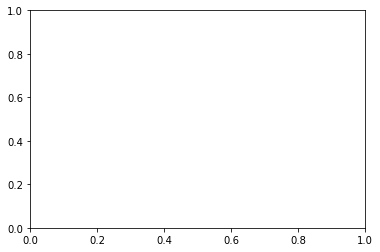

In [49]:
plt.plot(rewards)

It looks like something is going wrong here. 

In [52]:
from utils import query_policy

In [53]:
query_policy(trainer, env, np.array([0,0,0,0,0,0,0,0,0,1]), actions=[0,1,2,3,4,5,6,7,8,9])

array([8.7268853e-01, 1.7551240e-03, 8.4948372e-03, 1.5276692e-02,
       8.7164127e-04, 3.0396803e-04, 2.8898768e-02, 6.9322920e-04,
       7.0149995e-02, 8.6706434e-04], dtype=float32)

#### What is this agent doing?

- show the action probabilities?
- show that a deterministic agent will do terribly (e.g. DQN)?

#### New observations

or make this a coding exercise???

## Greedy vs random
<!-- multiple choice -->

Above, we saw our random baseline outperform our greedy baseline. Do you think this would always be the case?

- [ ] The random strategy always outperforms the greedy strategy. | What if the episode only had 1 step?
- [ ] The greedy strategy always outperforms the random strategy. | We saw the random strategy do better, though.
- [x] The random strategy performs better vs. greedy as the episode duration increases. | The greedy strategy works in the short-term, but not the long term.
- [ ] The greedy strategy performs better vs. random as the episode duration increases. | I think you have this backwards.

#### Outline

- observation space, action space
- variable candidates
- turn on resampling (or just have this always on by defualt)
- increase slate size
- long term effect
- etc
- TODO IF LOW ON TIME: not great, but if needed,could even do the recommender as module 2, where we provide it. and then module 4 we start building it, and also experimenting with observation and reward shaping
- REWARD SHAPING 2 types:
  - help it learn
  - actually change what you care about
- examples here: ethical recommendations
- some sort of total reward for the whole episode, not interim rewards
- other stuff
- or right and the offline RL
- possible modification: did they click? if not, sugar level is not updated.

#### Let's apply what we learned!